## Partial correlations and directed acyclic graphs
#### Drew Sandberg | ECON 611
#### andrew.sandberg@ndsu.edu

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#!pip install pingouin
import pingouin
from datlib.plots import corr_matrix_heatmap

In [2]:
#Variables
length = 10000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5

# this is a generator funciton with creates a list of lists!
lst_dct = {col:[] for col in cols }
lst_dct

{'P': [], 'Q': [], 'X': [], 'Y': [], 'Z': []}

### Populate the dataframe
Iterate over length of dataframe setting value for each key by formula... each formula will have some noise
which is generated by adding a random value to the value. The randdom value is generated from numpy.random, 
using a normal distribution and a defined mean and standard deviation.

In [3]:
for i in range(length):
    lst_dct["P"].append(25 + np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    
    # take last value of Q, multiply by 3, then add noise.
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    
    # take last value of Q, multiply by -1/2, then add noise.
    lst_dct["Y"].append(lst_dct["Q"][-1] * -0.5  +  np.random.normal(mu, sigma))
    
    # a. take last value of P * 2 and add it to 
    # b. the product of 1.5 * last value of X, then subtract
    # c. last value of Y * 2, then
    # d. add noise.
    lst_dct["Z"].append(lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

df = pd.DataFrame(lst_dct)
dag_keys = cols
df

,P,Q,X,Y,Z
0,21.628101,41.548333,128.337491,-17.257232,263.822177
1,29.110646,53.204660,155.195935,-27.158252,355.040525
2,24.820704,52.105211,157.675506,-23.254412,335.711404
3,29.953564,44.670938,131.762845,-19.254401,301.059385
4,23.463465,48.963570,149.250882,-25.224325,317.272210
...,...,...,...,...,...
9995,23.834125,51.545724,158.780762,-17.066266,322.355599
9996,22.943976,46.803584,131.879345,-18.936459,269.547103
9997,25.121372,47.943780,145.800758,-29.052145,326.819373
9998,25.168290,53.022051,163.926279,-25.892983,345.730815


<AxesSubplot:xlabel='Q', ylabel='Z'>

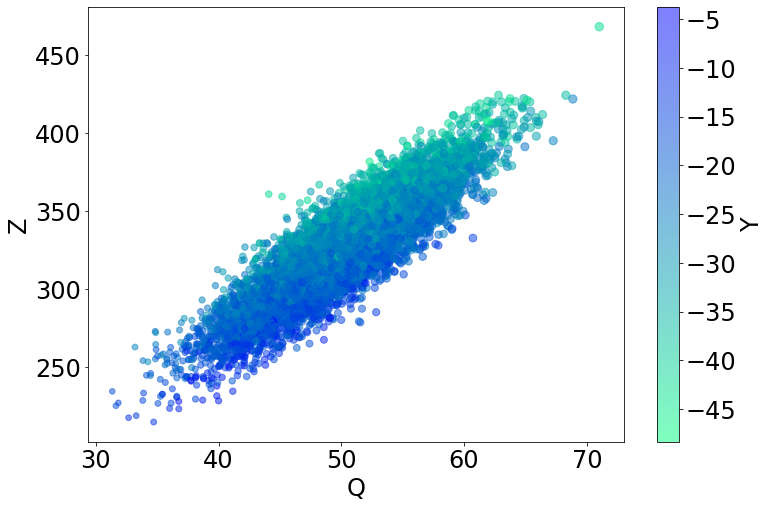

In [4]:
plt.rcParams.update({"font.size":24})
fig, ax = plt.subplots(figsize = (12,8))
df.plot.scatter(x="Q", y="Z", c="Y", s="Q", cmap='winter_r', alpha = 0.5, ax=ax)

In [5]:
# View correlations
df.corr()

,P,Q,X,Y,Z
P,1.000000,-0.006681,-0.004354,0.002321,0.155868
Q,-0.006681,1.000000,0.948209,-0.436855,0.885209
X,-0.004354,0.948209,1.000000,-0.415244,0.918078
Y,0.002321,-0.436855,-0.415244,1.000000,-0.675995
Z,0.155868,0.885209,0.918078,-0.675995,1.000000


## Partial Correlations

In [6]:
import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

,P,Q,X,Y,Z
0,-0.149615,-1.774662,4.095209,-1.792639,-6.399734
1,-0.291193,1.629396,-5.854544,3.756761,9.744833
2,-0.818810,-0.043976,-0.964064,1.761804,2.990101
3,1.256398,0.314088,-3.058946,2.698899,5.136670
4,0.205590,-0.834380,2.559012,-1.735233,-3.996346
...,...,...,...,...,...
9995,-1.148259,-0.641279,0.226718,2.691723,2.272889
9996,1.907109,2.363571,2.883197,-3.819773,-11.912446
9997,0.110421,-1.011207,0.684059,-1.108144,-0.196422
9998,0.678433,-1.085691,2.568679,-0.825555,-2.383260


In [7]:
# first, let's start with a residuals dictionary:
residuals = {}

# In a loop, take each key (e.g. column) of the data frame and set it as the dependent (exogenous) vairable
# and use the remaining keys (e.g. column names) as the independent variables...

# Going to use 'y_' as the variable name as that is my preferred nomenclature in regression work
# y is the dependent variable; X refers to the independent variables; 
# adding underscore to y as we do use y later on in the loop
for y_var in df.keys():
    X_vars = list(df.keys())  #Tried adding .remove(y) to end of this, but it chokes.
    X_vars.remove(y_var)
    X = df[X_vars]
    # print(X_vars) #see that the dependend variable is getting dropped in each iteration of the loop
    # initial estimate should include a constant; 
    # ## Not sure what this means... "this won't be the case ... we regress the errors"
    X["Constant"] = 1
    # get the values for the dependent variable... "y_var"
    y = df[[y_var]]  
    model = sm.OLS(y, X)
    results = model.fit()
    
    # We're going to add a new index to the residuals dictionary and pouplate it with a vector of 
    # residual values from the regression.
    residuals[y_var] = results.resid
    
residuals = pd.DataFrame(residuals)

# We're now looking a residual values where each column's values reflect the difference between
# the original value and the predicted value where in the given regression model.
# recall that each column was set as the dependent variable (or y variable) and the remaining
# columns are treated as teh independent variables.
residuals

,P,Q,X,Y,Z
0,-0.149615,-1.774662,4.095209,-1.792639,-6.399734
1,-0.291193,1.629396,-5.854544,3.756761,9.744833
2,-0.818810,-0.043976,-0.964064,1.761804,2.990101
3,1.256398,0.314088,-3.058946,2.698899,5.136670
4,0.205590,-0.834380,2.559012,-1.735233,-3.996346
...,...,...,...,...,...
9995,-1.148259,-0.641279,0.226718,2.691723,2.272889
9996,1.907109,2.363571,2.883197,-3.819773,-11.912446
9997,0.110421,-1.011207,0.684059,-1.108144,-0.196422
9998,0.678433,-1.085691,2.568679,-0.825555,-2.383260


#### Professor Caton says...
The partial correlation is the negative correlation of the residuals generated by the above set of regressions. For all relevant partial correlations ( **|𝑝𝑐𝑜𝑟𝑟(𝑋,𝑌)|<1** ), we multiply the partial correlation by  −1 . If you like, you can use df.fillna(1) to replace the null values in the diagnol of the dataframe.

In [8]:
residuals.corr().round(2)

,P,Q,X,Y,Z
P,1.00,0.00,0.58,-0.62,-0.70
Q,0.00,1.00,-0.52,0.07,0.01
X,0.58,-0.52,1.00,-0.74,-0.83
Y,-0.62,0.07,-0.74,1.00,0.89
Z,-0.70,0.01,-0.83,0.89,1.00


In [9]:
# it just occurred to me that the '.' acts just like '%>%' operator in R
# So, functionally, we're going invert pos/neg correlation values for anything less than 1.
# but for reasons I don't really undertand, we're going to reset anything that was a perfect correlation back to 1.
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,P,Q,X,Y,Z
P,1.00,-0.00,-0.58,0.62,0.70
Q,-0.00,1.00,0.52,-0.07,-0.01
X,-0.58,0.52,1.00,0.74,0.83
Y,0.62,-0.07,0.74,1.00,-0.89
Z,0.70,-0.01,0.83,-0.89,1.00


### Using pingouin as a shortcut

See that in previous cells, we've:
1. built the regressions for each item in the dataframe using ordinary least squares
2. extracted the residual values from the OLS model
3. inverted teh sign of all values where the correlation was less than 1 and ...
4. arrived at the partial correlation values

#### And all of that ...

can be wrapped up by using pcorr() method of the pingouin module.

In [10]:
df.pcorr().round(2)

,P,Q,X,Y,Z
P,1.00,-0.00,-0.58,0.62,0.70
Q,-0.00,1.00,0.52,-0.07,-0.01
X,-0.58,0.52,1.00,0.74,0.83
Y,0.62,-0.07,0.74,1.00,-0.89
Z,0.70,-0.01,0.83,-0.89,1.00


### Heatmap viz of correlations

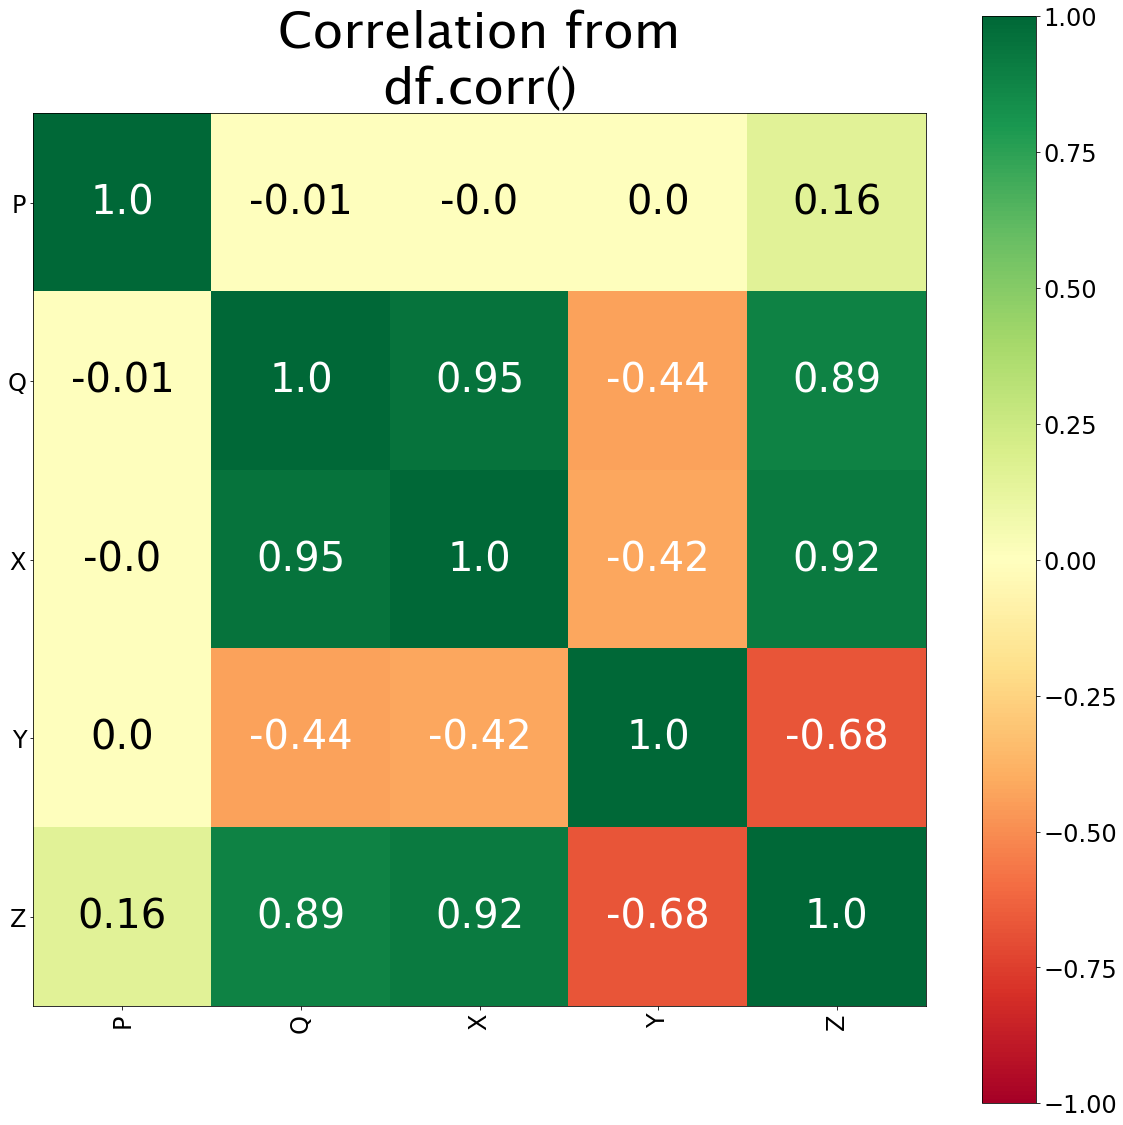

In [11]:
corr_matrix_heatmap(df.corr(),
                    save_fig = False,
                    pp = None, 
                    title = "Correlation from\ndf.corr()")

### Heatmap viz of partial correlations...

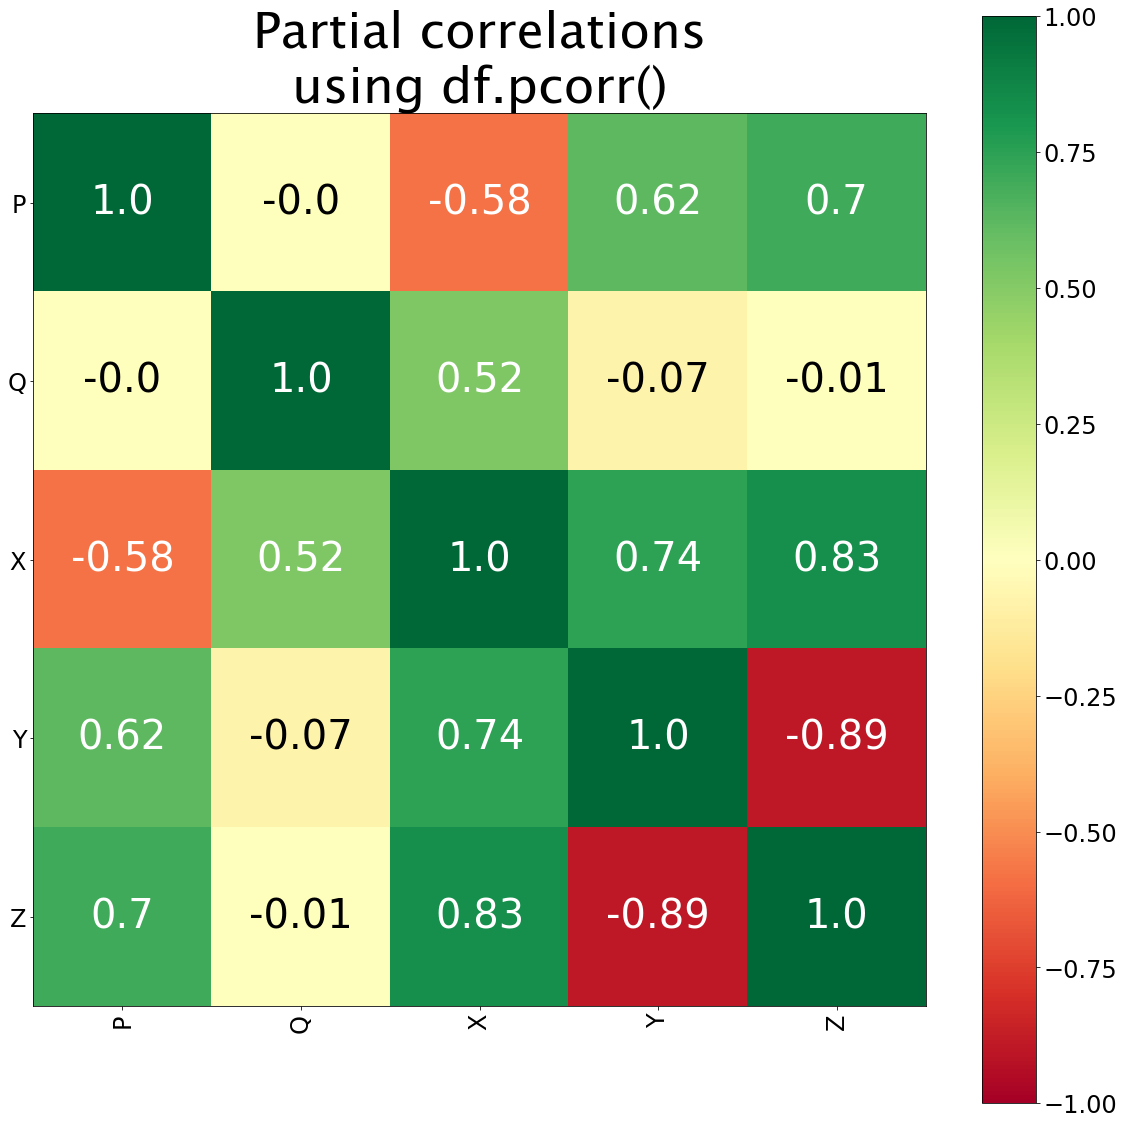

In [12]:
corr_matrix_heatmap(df.pcorr(), 
                   title = "Partial correlations\nusing df.pcorr()")

## Professor Caton says...
While this is useful, we will need to calculate the statistical significance of the these partial correlations. To help develop an intuitive interpretation, we will regress one error term on the other with no constant included on the right hand side of the regression equation. The p-value of the beta estimate is the p-value of the partial correlation. Later on, we will use the pingouin module to perform these calculation.

In [13]:
residuals.items

<bound method DataFrame.items of              P         Q         X         Y          Z
0    -0.149615 -1.774662  4.095209 -1.792639  -6.399734
1    -0.291193  1.629396 -5.854544  3.756761   9.744833
2    -0.818810 -0.043976 -0.964064  1.761804   2.990101
3     1.256398  0.314088 -3.058946  2.698899   5.136670
4     0.205590 -0.834380  2.559012 -1.735233  -3.996346
...        ...       ...       ...       ...        ...
9995 -1.148259 -0.641279  0.226718  2.691723   2.272889
9996  1.907109  2.363571  2.883197 -3.819773 -11.912446
9997  0.110421 -1.011207  0.684059 -1.108144  -0.196422
9998  0.678433 -1.085691  2.568679 -0.825555  -2.383260
9999 -0.286828  0.526038  1.969700 -2.313218  -4.922839

[10000 rows x 5 columns]>

In [14]:
# dictionary for partial correlation p-values...
# to better understand the logic of the loop, i'm replacing:
# y, Y = outer_key, outer_value
# x, X = inner_key, inner_value

pcorr_pvalues = {}

#Looping through keys(columns) left to right, then reading values top to bottom...
# the lower case x, y  is the column name
# the upper case X, Y is the item value!

for outer_key, outer_value in residuals.items():
    #we'll put each residvual value into a dictionary
    pcorr_pvalues[outer_key] = {}
    # We'll use a second loop to run left to right through the columns and top to bottom throug the rows...
    for inner_key, inner_value in residuals.items():
        
        # now comparing the current y value to all x values (except itself...)
        if inner_key != outer_key:
            # now using the matrix coordinates of [y][x], set the p-values ....
            pcorr_pvalues[outer_key][inner_key] = sm.OLS(outer_value,inner_value).fit().pvalues[inner_key]
        # when evaluating the df.item against itself... just set to NaN.
        else:
            pcorr_pvalues[outer_key][inner_key] = np.NaN
            
pd.DataFrame(pcorr_pvalues).round(2)

,P,Q,X,Y,Z
P,NaN,0.84,0.0,0.0,0.00
Q,0.84,NaN,0.0,0.0,0.59
X,0.00,0.00,NaN,0.0,0.00
Y,0.00,0.00,0.0,NaN,0.00
Z,0.00,0.59,0.0,0.0,NaN


#### Dupe of above... using y, Y; x, X

In [15]:
# dictionary for partial correlation p-values...
pcorr_pvalues = {}

#Looping through keys(columns) left to right, then reading values top to bottom...
# the lower case x, y  is the column name
# the upper case X, Y is the item value!

for y, Y in residuals.items():
    #we'll put each residvual value into a dictionary
    pcorr_pvalues[y] = {}
    # We'll use a second loop to run left to right through the columns and top to bottom throug the rows...
    for x, X in residuals.items():
        
        # now comparing the current y value to all x values (except itself...)
        if x != y:
            # now using the matrix coordinates of [y][x], set the p-values ....
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        # when evaluating the df.item against itself... just set to NaN.
        else:
            pcorr_pvalues[y][x] = np.NaN
            
pd.DataFrame(pcorr_pvalues).round(2)

,P,Q,X,Y,Z
P,NaN,0.84,0.0,0.0,0.00
Q,0.84,NaN,0.0,0.0,0.59
X,0.00,0.00,NaN,0.0,0.00
Y,0.00,0.00,0.0,NaN,0.00
Z,0.00,0.59,0.0,0.0,NaN


### Building causal skelton using partial correlations

Here, 

In [16]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph   

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [17]:

import copy
p_val = .01
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        for c_var in control_vars:
            c_used = copy.copy(controls_used)
            if y in undirected_graph[x]:

                c_used.append(c_var)
                test = df.partial_corr(x = x, 
                                       y = y, 
                                       covar=c_used,
                                       method = "pearson")
                if test["p-val"].values[0] > p_val: 
                    undirected_graph[x].remove(y)
                    #breakout of the for loop
                    break
                else:
                    remaining_controls = copy.copy(control_vars)
                    remaining_controls.remove(c_var)
                    # recursive function that iterates through remaining variables 
                    #  uses them as controls statistical significance holds without them,
                    #  otherwise break
                    check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
                
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, 
                                       y = y, 
                                       covar = None,
                                       method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph



In [18]:
undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'P': ['Z'],
 'Q': ['X', 'Y'],
 'X': ['Q', 'Z'],
 'Y': ['Q', 'Z'],
 'Z': ['P', 'X', 'Y']}

### Graph the skeleton...

In [19]:
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    
    
    
    
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            #print(key2, key)  ... Drew investigation; what's key and key2?
            if (key2, key) not in edges:
                edge = (key.replace(" ", "\n"), key2[0].replace(" ", "\n"))
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))
                
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
    
    fig, ax = plt.subplots(figsize =(20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    
    plt.title(title, fontsize=30)
    
    nx.draw_networkx(graph,
                     pos,
                     node_color = color_map,
                     node_size = 1000,
                     with_labels =True,
                     arrows = False,
                     font_size = 20,
                     alpha = 1,
                     font_color = "w",
                     ax = ax)
    
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels = edge_labels,
                                 font_color = "green",
                                 font_size = 20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    plt.show()
    

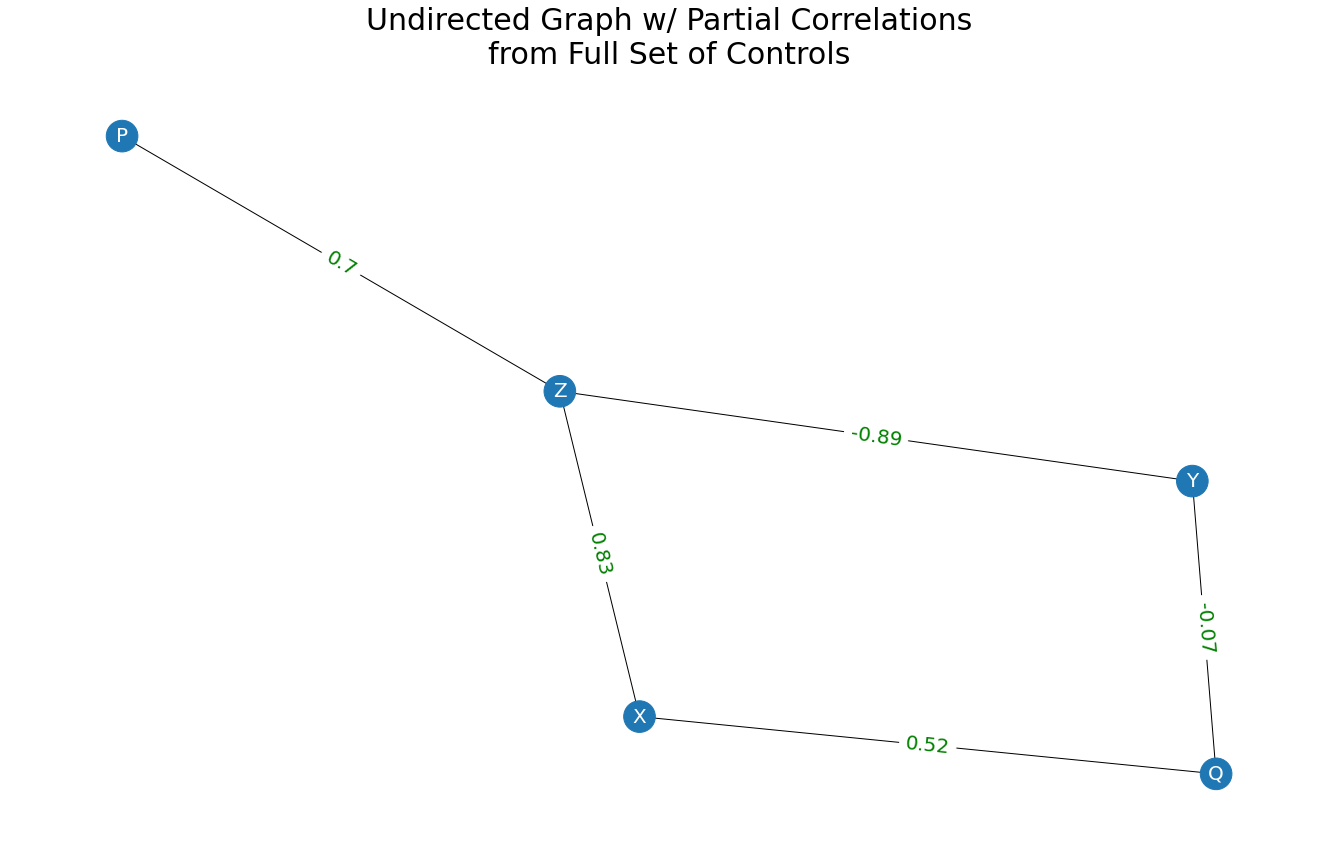

In [20]:
graph_DAG(
    undirected_graph,
    df,
    title = "Undirected Graph w/ Partial Correlations\nfrom Full Set of Controls"
)

In [21]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) -2

model = c.estimate(return_type = "dag",
                   variant = "orig",
                   significance_laevel = p_val,
                   max_cond_vars = max_cond_vars,
                   ci_test = "pearsonr")

edges = model.edges()


  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('Y', 'Z'), ('X', 'Z'), ('P', 'Z'), ('Q', 'Y'), ('Q', 'X')])

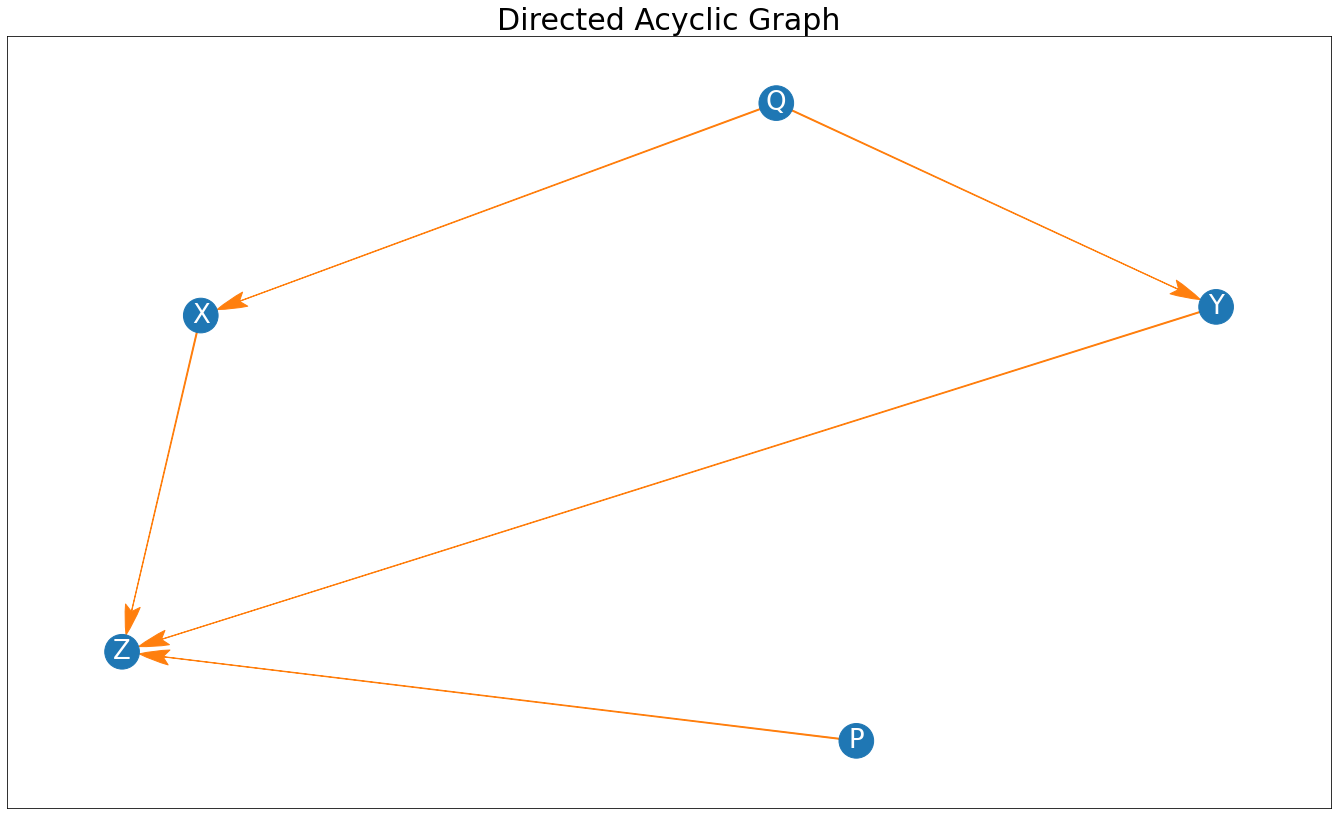

In [22]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

## Revising graph_DAG Function

keep control: X
keep control: P
('Y', 'Z') ['X', 'P']
keep control: Y
keep control: P
('X', 'Z') ['Y', 'P']
keep control: Y
keep control: X
('P', 'Z') ['Y', 'X']
('Q', 'Y') []
('Q', 'X') []


OutEdgeView([('Y', 'Z'), ('X', 'Z'), ('P', 'Z'), ('Q', 'Y'), ('Q', 'X')])

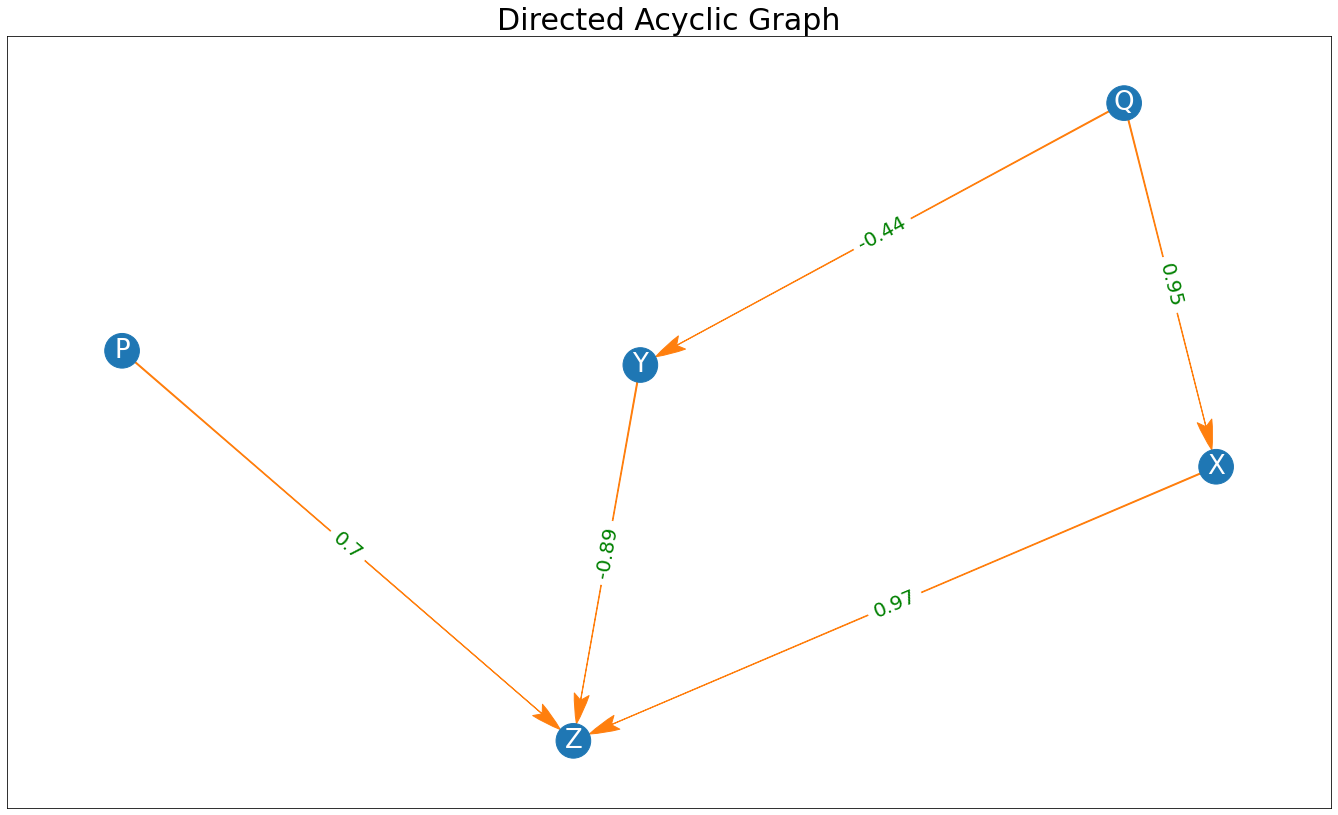

In [23]:
def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges